# 사진 묘사하기 시험 유형 만들기

사진 묘사하기 시험도 마찬가지 GPT-4-vision API는 특히 더 느리기 때문에 시험을 위한 준비를 먼저 해둬서 비싸고 재반복하는 연산은 미리 해두는게 좋음

- 사진 준비하기
- 사진에 대한 Reference 설명 만들기
- 이미지, Reference 설명을 참조하여 사용자의 설명 평가하기

In [1]:
import pandas as pd
from openai import OpenAI
from IPython.display import Image

client = OpenAI()

## create_desc 함수 만들기

In [2]:
import base64

In [3]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [33]:
def create_desc(img_path):
    base64_image = encode_image(img_path)
    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=[
            {
              "role": "user",
              "content": [
                {"type": "text", "text": "Describe given image."},
                {
                  "type": "image_url",
                  "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}",
                  },
                },
              ],
            }
            ],
            max_tokens=300
        )
    text = response.choices[0].message.content
    return text

In [25]:
!ls ./imgs

1.jpg 2.jpg 3.jpg


In [22]:
img_path = "./imgs/2.jpg"

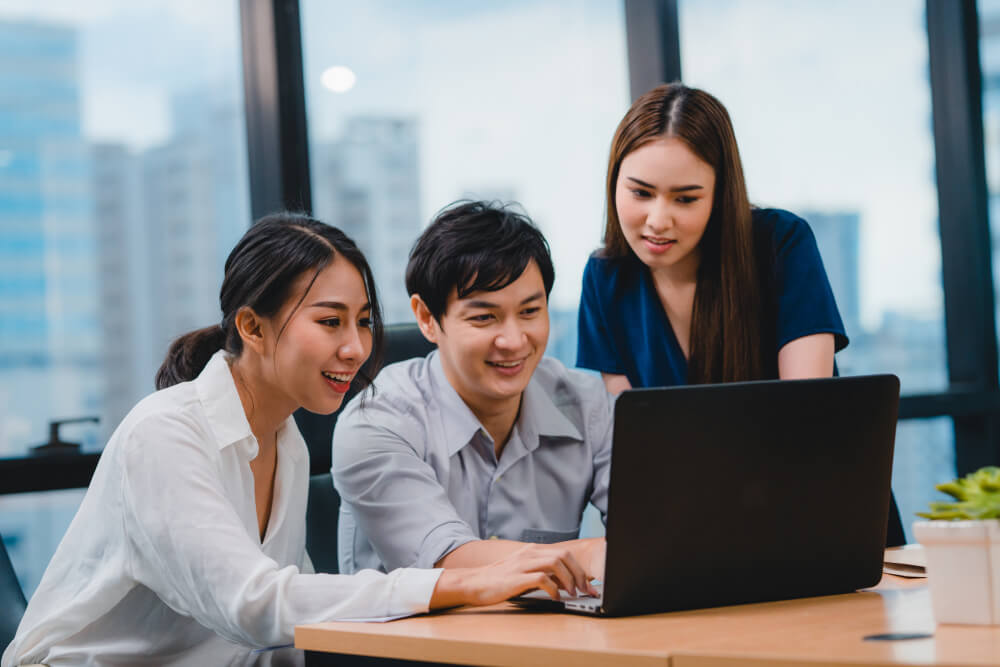

In [23]:
Image(img_path, width=480)

In [24]:
create_desc(img_path=img_path)

'이 이미지에는 세 명의 사람이 노트북 컴퓨터 주위에 모여 있는 장면이 포함되어 있습니다. 그들은 밝은 실내 사무실 공간에 있으며, 큰 창문을 통해 도시의 건물들이 보입니다. 이들은 업무 중이거나 협업 중인 것처럼 보이며, 노트북 화면을 함께 보면서 무언가에 대해 대화하고 있는 듯합니다. 왼쪽에 있는 여성은 흰색 셔츠를 입고 있고, 가운데에 있는 남성은 회색 셔츠를 입고 있으며, 오른쪽의 여성은 짙은 파란색 상의를 입고 있습니다. 모두 집중하며 화면을 보고 있는 표정이며, 긍정적이고 협력적인 분위기를 느낄 수 있습니다.'

## 이미지 모두 불러오기

In [26]:
from glob import glob

In [27]:
img_list = glob("./imgs/*.jpg")

In [28]:
img_list

['./imgs/2.jpg', './imgs/3.jpg', './imgs/1.jpg']

In [34]:
record_list = []

for i, img_path in enumerate(img_list):
    desc = create_desc(img_path)
    record = {"img_path": img_path, "desc": desc}
    print(record)

    record_list.append(record)

{'img_path': './imgs/2.jpg', 'desc': 'The image depicts three individuals, two women and one man, in a professional office setting. They appear to be engaged in a collaborative task, looking at a laptop screen together. The man is seated at the desk, operating the laptop, while the women are standing close by, leaning in to better view the screen. All three individuals seem focused and interested in what is being displayed on the laptop. They are dressed in business casual attire. The room has large windows that offer a view of the city skyline, suggesting that they are in a high-rise building. The setting conveys a sense of teamwork and corporate engagement.'}
{'img_path': './imgs/3.jpg', 'desc': 'The image depicts a celebratory scene, possibly taken at a wedding reception. There are six people visible at a table adorned with bouquets of flowers, including red roses and pink gerberas. To the right, a young boy is blowing out candles on a cake, suggesting a dual celebration of perhaps 

In [35]:
!mkdir -p ./data/speaking__describe_img

In [36]:
save_dir = "./data/speaking__describe_img"

In [37]:
df = pd.DataFrame(record_list)
df

,img_path,desc
0,./imgs/2.jpg,"The image depicts three individuals, two women..."
1,./imgs/3.jpg,"The image depicts a celebratory scene, possibl..."
2,./imgs/1.jpg,The image shows a cozy domestic scene with thr...


In [38]:
df.to_csv(f"{save_dir}/desc_img.csv", index=False)

## 평가하기

In [39]:
from langchain_openai import ChatOpenAI
from typing import Union
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

In [40]:
model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.8) # CoT 는 다양한 샘플을 만들어야하기 때문에 temperature를 올려야함

In [42]:
class Evaluation(BaseModel):
    score: int = Field(description="사진 묘사하기 표현 점수. 0~10점")
    feedback: str = Field(description="사진 묘사하기를 더 잘 할 수 있도록하는 자세한 피드백. Markdown형식, 한국어로.")

In [43]:
parser = JsonOutputParser(pydantic_object=Evaluation)
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"title": "Score", "description": "\\uc0ac\\uc9c4 \\ubb18\\uc0ac\\ud558\\uae30 \\ud45c\\ud604 \\uc810\\uc218. 0~10\\uc810", "type": "integer"}, "feedback": {"title": "Feedback", "description": "\\uc0ac\\uc9c4 \\ubb18\\uc0ac\\ud558\\uae30\\ub97c \\ub354 \\uc798 \\ud560 \\uc218 \\uc788\\ub3c4\\ub85d\\ud558\\ub294 \\uc790\\uc138\\ud55c \\ud53c\\ub4dc\\ubc31. Markdown\\ud615\\uc2dd, \\ud55c\\uad6d\\uc5b4\\ub85c.", "type": "integer"}}, "required": ["score", "feedback"]}\n```'

In [44]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

human_prompt_template = HumanMessagePromptTemplate.from_template(
                            "사진 묘사하기 영어 시험이다. 사용자의 응답을 Reference와 비교하여 평가하라.\n사용자: {input}\Reference: {ref}\n{format_instructions}",
                            partial_variables={"format_instructions": format_instructions})

prompt = ChatPromptTemplate.from_messages(
    [
        human_prompt_template,
    ])

In [45]:
eval_chain = prompt | model | parser

In [47]:
sample = df.iloc[0]

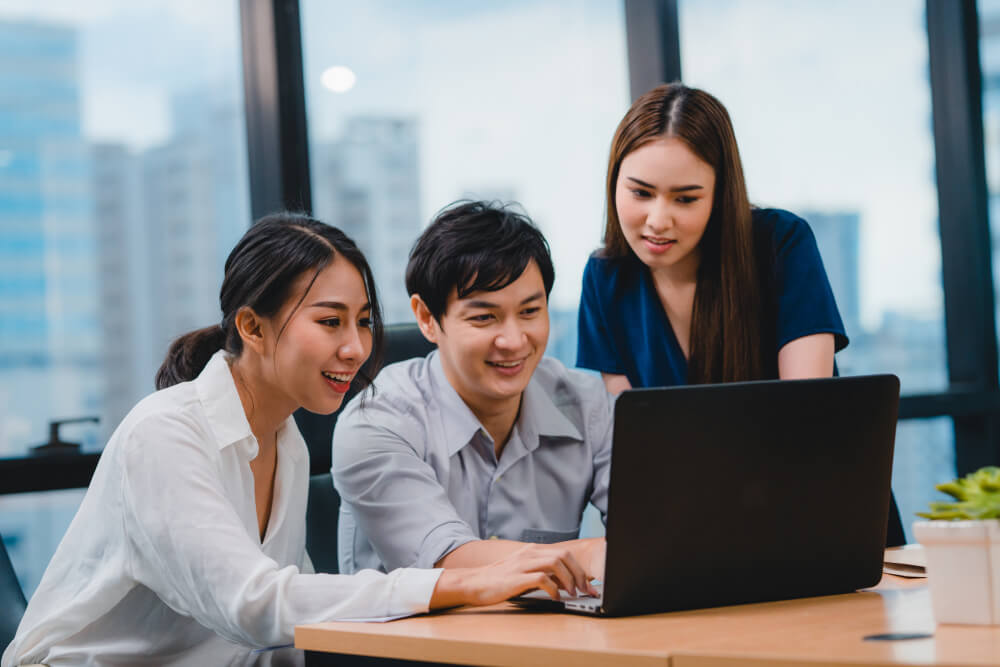

In [48]:
Image(sample['img_path'], width=480)

In [49]:
sample['desc']

'The image depicts three individuals, two women and one man, in a professional office setting. They appear to be engaged in a collaborative task, looking at a laptop screen together. The man is seated at the desk, operating the laptop, while the women are standing close by, leaning in to better view the screen. All three individuals seem focused and interested in what is being displayed on the laptop. They are dressed in business casual attire. The room has large windows that offer a view of the city skyline, suggesting that they are in a high-rise building. The setting conveys a sense of teamwork and corporate engagement.'

In [50]:
result = eval_chain.invoke({"input": "Three people are looking at a monitor.",
                            "ref": sample['desc']})

In [51]:
result

{'score': 4,
 'feedback': '사용자의 응답은 사진의 기본적인 내용을 전달하고 있으나, 참조 답변에 비해 세부적인 정보가 부족합니다. 참조 답변에서는 배경, 참여자의 성별과 복장, 그리고 그들이 어떤 활동을 하는지에 대한 구체적인 묘사가 있습니다. 사용자의 응답에는 이러한 세부 정보가 빠져 있어, 사진의 전체적인 맥락과 분위기를 이해하는 데에 다소 한계가 있을 수 있습니다. 또한, 업무 환경과 창문으로 보이는 도시 스카이라인을 언급하는 등의 추가 정보를 제공함으로써 더욱 풍부한 묘사가 가능할 것입니다. 다음에는 인물들의 상호작용, 주변 환경, 그리고 그들이 처한 상황에 대해 더욱 구체적으로 서술해 보시기 바랍니다.'}